In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from numpy.linalg import inv
import sys

sys.path.append('../../')
from PortfolioAnalysis import Backtest
from PortfolioAnalysis import Model

In [14]:
# load data
market_view = pd.read_csv("../Risk_Parity_Model/view.csv",index_col = 0)
sub_view = pd.read_csv("../Subjective_View_Setting/Subjective_View.csv",index_col = 0)
df_history = pd.read_excel("../../Data/Index.xls",index_col=0).dropna()
df_history.drop(["信息技术指数","金融指数","中债-国开行债券总财富(7-10年)指数","可选消费指数","房地产指数"],axis=1,inplace=True)

colsn = df_history.columns
df_date = market_view.index
df_fr = pd.DataFrame(np.repeat(0,1134))

In [27]:
BL_weight = []
start = 0
while(1):
    print("count = %d"%int(start/63))
    if(start+63>len(df_date)):
        break
    market_view_rw = np.array(market_view.iloc[start,:])
    sub_view_rw = np.array(sub_view.iloc[start,:-1]).reshape(1,15)
    Q = np.array([sub_view.iloc[start,-1]])

    BLM = Model.BLModel(df_date[start:start+63], df_history[start:start+252*6], df_fr[start:start+63],market_view_rw, sub_view_rw, Q,tau=1.2,LC=np.array([[1.4]]))

    BL_weight.append(BLM.optimize())
    start+=63

count = 0
Status: Optimization terminated successfully.
count = 1
Status: Optimization terminated successfully.
count = 2
Status: Optimization terminated successfully.
count = 3
Status: Optimization terminated successfully.
count = 4
Status: Optimization terminated successfully.
count = 5
Status: Optimization terminated successfully.
count = 6
Status: Optimization terminated successfully.
count = 7
Status: Optimization terminated successfully.
count = 8
Status: Optimization terminated successfully.
count = 9
Status: Optimization terminated successfully.
count = 10
Status: Optimization terminated successfully.
count = 11
Status: Optimization terminated successfully.
count = 12
Status: Optimization terminated successfully.
count = 13
Status: Optimization terminated successfully.
count = 14
Status: Optimization terminated successfully.
count = 15
Status: Optimization terminated successfully.
count = 16
Status: Optimization terminated successfully.
count = 17
Status: Optimization terminate

In [28]:
view = np.array(BL_weight)
view = np.repeat(view,63,axis=0)

In [29]:
BT = Backtest.Backtest(df_date, df_history[252*6:252*6+63*18], pd.DataFrame(view), df_fr, 'D')
BT.get_info()

,Sharpe,Annualized Return,Annualized Volatility,Maximum Drawdown
Value,0.742996,0.042923,0.05777,0.04751


In [30]:
df_bm = pd.DataFrame(np.repeat(np.array([[1/15,]*15]),63*18,axis=0))

In [31]:
BTM = Backtest.Backtest(df_date, df_history[252*6:252*6+63*18], df_bm, df_fr, 'D')
BTM.get_info()

,Sharpe,Annualized Return,Annualized Volatility,Maximum Drawdown
Value,0.021748,0.025452,1.170299,0.298374


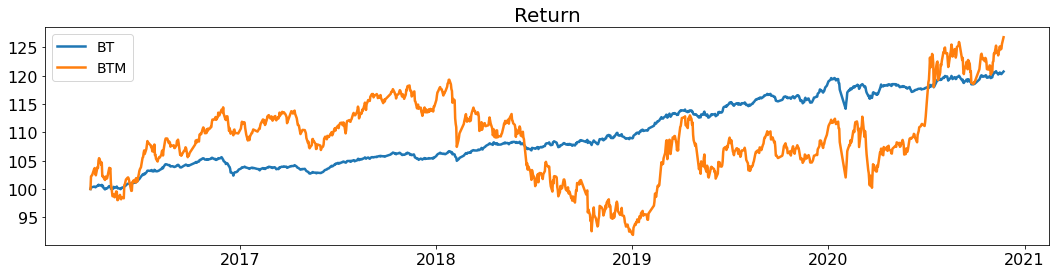

In [32]:
Backtest.Plot2(df_date,BT.df_asset,BTM.df_asset,"Return","BT","BTM")

In [33]:
Asset = pd.DataFrame([BT.df_asset,BTM.df_asset]).T
Asset.index = df_date
Asset.columns = ['BL','Market']

Asset.to_csv("BL_Asset.csv")

df_sbj = pd.DataFrame(view,index = df_date)
df_sbj.columns = colsn
df_sbj.to_csv("view.csv")

In [34]:
BT.get_info().to_csv("../../Data/Backtest_BL.csv")